## 프로젝트: 뉴스기사 요약해보기
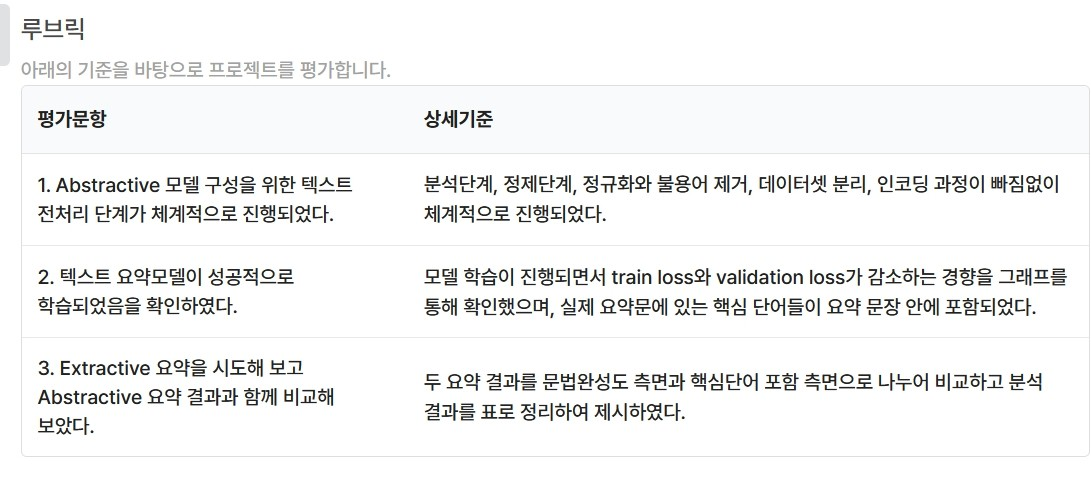

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import summa
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from importlib.metadata import version
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.2.0


### Step 1. 데이터 수집하기

In [2]:
# 데이터 불러오기 
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
orig_df = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('전체 샘플수 :', (len(orig_df)))

전체 샘플수 : 98401


In [4]:
orig_df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [5]:
orig_df.sample(5)

,headlines,text
68871,Ishant named Delhi Ranji captain after Gambhir...,Pacer Ishant Sharma has replaced 36-year-old G...
42277,"Advani now holds Indian, Asian, World titles i...",Indian billiards player Pankaj Advani beat his...
89278,What are VVPAT machines that will be used for ...,A Voter Verified Paper Audit Trail (VVPAT) mac...
80368,"To avoid getting eaten, spiders walk like ants...",Some jumping spiders mimic ants walking stance...
26586,"IndusInd Bank profit rises 24% to Ã¢ÂÂ¹1,036 ...",IndusInd Bank on Tuesday reported a 23.8% year...


### Step 2. 데이터 전처리하기 (추상적 요약)

In [6]:
# 컬럼명으로 text, summary로 해서 데이터프레임 복사 
data = orig_df[['text', 'headlines']]
data.columns = ['Text', 'Summary']
data.head(5)

,Text,Summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


#### 중복 처리 

In [7]:
print('전체 샘플의 수 :', len(data))
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

전체 샘플의 수 : 98401
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
# 중복 샘플 제거
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [9]:
# Null 유무 확인
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


Null 없이 깔끔하다. 

#### 텍스트 정규화와 불용어 제거 

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [13]:
# 임의의 문장 전처리 
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br/>for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [14]:
# Text 전처리 
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [15]:
# Summary 전처리 
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [16]:
# 빈값 Null로 변환 
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


/tmp/ipykernel_32/1361788361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'] = clean_text
/tmp/ipykernel_32/1361788361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Summary'] = clean_summary
/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [17]:
# Null 확인 
data.isnull().sum()

Text       0
Summary    0
dtype: int64

Null 없이 깔끔하다. 

In [18]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 샘플의 최대 길이 정하기 

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


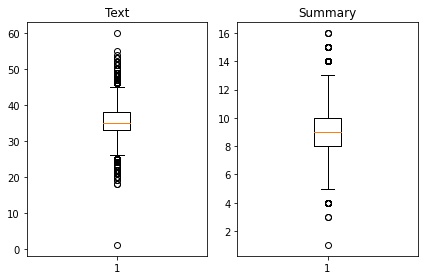

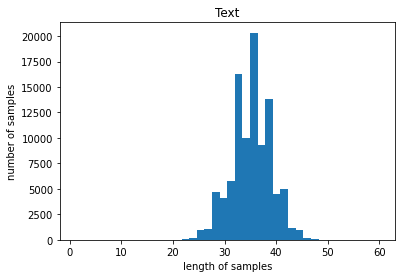

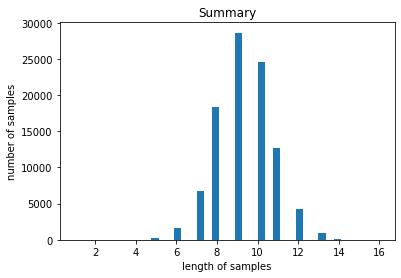

In [19]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

텍스트의 길이는 주로 30-40 사이에 분포하고, 요약은 8-10 사이에 분포한다.    
큰 이상치 없이 길이의 범위가 작으므로 최대값을 샘플의 최대 길이로 정한다. 

In [20]:
text_max_len = 60
summary_max_len =16
print('=3')

=3


#### 시작 토큰과 종료 토큰 추가하기

In [21]:
# 시작, 종료 토큰 추가
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

/tmp/ipykernel_32/3867948118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_32/3867948118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')


,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [22]:
# input, target 설정 
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


#### 훈련 데이터, 테스트 데이터 분리

In [23]:
# encoder_input의 index로 넣을 임의의 정수 시퀀스 생성 
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[55655 61590 61235 ...  7927 45920 22801]


In [24]:
# 데이터 섞기 
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [25]:
# 테스트 데이터 크기 
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [26]:
# 데이터 분할
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### 정수 인코딩 

In [27]:
# Text에서 단어 집합 생성 
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [28]:
# Text에서 단어 빈도 확인 
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69490
등장 빈도가 6번 이하인 희귀 단어의 수: 47362
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22128
단어 집합에서 희귀 단어의 비율: 68.1565692905454
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4936197405174085


희귀 단어의 개수에 비해 비율은 매우 낮다. 

In [29]:
# Text에서 사용빈도가 높은 단어만으로 단어 집합 생성 
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[81, 3700, 4954, 3904, 1270, 346, 642, 1175, 450, 1, 3221, 384, 6894, 533, 12555, 6808, 10051, 4, 237, 8281, 1328, 585, 763, 1743, 298, 1], [106, 247, 7486, 1354, 793, 4118, 4119, 269, 960, 1321, 106, 1737, 793, 1354, 793, 178, 43, 994, 3020, 374, 106, 1354, 793, 1552, 302, 498, 221, 1552, 290], [5835, 1593, 740, 8687, 27, 317, 53, 734, 79, 587, 5215, 2122, 200, 85, 88, 1, 740, 1124, 3005, 1136, 9, 78, 2014, 4477, 1249, 734, 5215, 107, 734, 1916, 4775, 1426, 200, 586]]


In [31]:
# Summary에서 단어 집합 생성 
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30123
등장 빈도가 5번 이하인 희귀 단어의 수: 19694
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10429
단어 집합에서 희귀 단어의 비율: 65.37861434784053
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6536100916016405


In [33]:
# Summary에서 사용빈도가 높은 단어만으로 단어 집합 생성 
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 16, 384, 329, 50, 9539, 2005], [1, 146, 34, 2162, 1416, 7, 6189, 6, 552, 1644], [1, 4397, 2302, 2303, 130, 9, 463, 4126, 12, 27, 197], [1, 498, 4008, 2395, 3, 843, 995, 6530, 4, 34], [1, 8, 3, 21, 671, 222, 8195, 1256, 1766, 699]]
target
decoder  [[16, 384, 329, 50, 9539, 2005, 2], [146, 34, 2162, 1416, 7, 6189, 6, 552, 1644, 2], [4397, 2302, 2303, 130, 9, 463, 4126, 12, 27, 197, 2], [498, 4008, 2395, 3, 843, 995, 6530, 4, 34, 2], [8, 3, 21, 671, 222, 8195, 1256, 1766, 699, 2]]


In [34]:
# Summary 길이가 1인 샘플 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### 패딩하기 

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

#### 모델 설계하기

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 47s 130ms/step - loss: 4.2758 - val_loss: 3.9044
Epoch 2/50
308/308 [==============================] - 40s 131ms/step - loss: 3.7933 - val_loss: 3.6309
Epoch 3/50
308/308 [==============================] - 41s 134ms/step - loss: 3.5391 - val_loss: 3.4469
Epoch 4/50
308/308 [==============================] - 43s 138ms/step - loss: 3.3507 - val_loss: 3.3035
Epoch 5/50
308/308 [==============================] - 42s 137ms/step - loss: 3.1982 - val_loss: 3.2042
Epoch 6/50
308/308 [==============================] - 42s 137ms/step - loss: 3.0688 - val_loss: 3.1174
Epoch 7/50
308/308 [==============================] - 42s 138ms/step - loss: 2.9586 - val_loss: 3.0510
Epoch 8/50
308/308 [==============================] - 42s 137ms/step - loss: 2.8626 - val_loss: 2.9854
Epoch 9/50
308/308 [==============================] - 42s 137ms/step - loss: 2.7771 - val_loss: 2.9395
Epoch 10/50
308/308 [==============================] - 42s 138ms/step - l

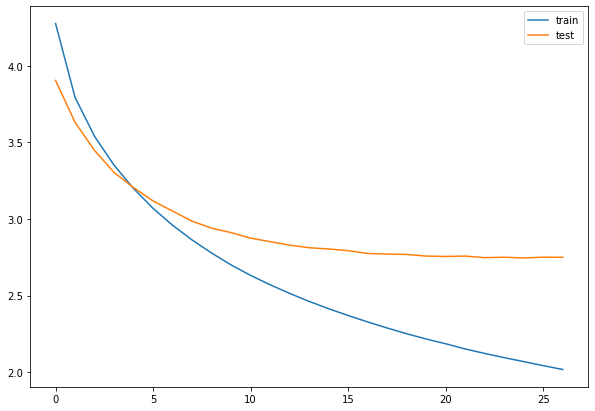

In [41]:
# 시각화 
plt.figure(figsize = (10, 7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [45]:
# 단어 시퀀스 완성 함수 
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [138]:
for i in range(0, 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상적 - 정제 예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : addressing rajya sabha minister state home affairs hansraj ahir said people arrested cases attacks journalists maximum cases recorded people arrested cases reports claimed journalists killed country 
실제 요약 : people held for attacking journalists between 
추상적 - 정제 예측 요약 :  only of killed in cases reported in


원문 : india voluntarily contributed un fund help developing countries actively participate discussion tax issues becoming first country voluntarily contribute un tax trust fund called voluntary contributions since establishment handing cheque india expressed hope countries would also contribute 
실제 요약 : india st to contribute to un tax fund 
추상적 - 정제 예측 요약 :  india to give up to un development


원문 : central crime branch police monday arrested people across karnataka allegedly cheated sub inspector aspirants promising leak question paper recruitment test several candidates exchanged money question paper paper given police said total lakh cash lakh cheques recovered 
실제 요약 : he

In [141]:
ab_result['Text'][i] = seq2text(encoder_input_test[i])
ab_result['Summary'][i] = seq2summary(decoder_input_test[i])
ab_result['Abstractive'][i] = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
ab_result.head()

/tmp/ipykernel_32/1723499727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_result['Text'][i] = seq2text(encoder_input_test[i])
/tmp/ipykernel_32/1723499727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_result['Summary'][i] = seq2summary(decoder_input_test[i])
/tmp/ipykernel_32/1723499727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_result['Abstractive'][i] = decode_sequence(encoder_input_test[i].reshape(1, t

,Text,Summary,Abstractive
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,only of killed in cases reported in
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,india to give up to un development
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,arrested for using fake data to andhra
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,pm modi to launch india space mission in india
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,india first yoga yoga day in the mumbai


정제를 거치면서 원문 자체가 문법에 맞지 않게 변하다보니, 예측 역시 주요 단어를 포함하지 못하고 문법도 틀리다.     
노드에서 진행했던 아마존 리뷰보다 오히려 못한 것 같다. 

### Step 5. Summa을 이용해서 추출적 요약해보기

In [90]:
# pip list | grep summa

summa                         1.2.0
Note: you may need to restart the kernel to use updated packages.


In [88]:
from summa.summarizer import summarize

In [151]:
for idx, (head, text) in enumerate(zip(orig_df['headlines'], orig_df['text'])):
    if idx == 10:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, ratio=0.35))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

일부 문장은 요약문을 추출하지 못한다. 

In [160]:
data['Extractive'] = orig_df['text'].apply(lambda x: summarize(x, ratio = 0.4))
data.head()

/tmp/ipykernel_32/2303310512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Extractive'] = orig_df['text'].apply(lambda x: summarize(x, ratio = 0.4))


,Text,Summary,decoder_input,decoder_target,Abstractive,Extractive
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...,only of killed in cases reported in,upGrad's Online Power Learning has powered 3 l...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...,india to give up to un development,Users get one CRED coin per rupee of bill paid...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...,arrested for using fake data to andhra,The match witnessed India getting all out for ...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...,pm modi to launch india space mission in india,"Also, customers have options to insure against..."
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...,india first yoga yoga day in the mumbai,Speaking about the sexual harassment allegatio...


In [161]:
ex_result = data[['Text', 'Summary', 'Extractive']]
ex_result.head()

,Text,Summary,Extractive
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,upGrad's Online Power Learning has powered 3 l...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,Users get one CRED coin per rupee of bill paid...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,The match witnessed India getting all out for ...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,"Also, customers have options to insure against..."
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,Speaking about the sexual harassment allegatio...


데이터 전처리를 거친 샘플은 구두점과 따옴표가 모두 사라져서 아무리 ratio를 높이고 words로 조절해도 summarize는 요약문을 출력하지 못했다.   
차라리 원문 그대로 summarize 하니 ratio를 0.4로 높였을 때 요약문이 나왔다.     
원문의 40% 길이라 요약이라고 부르긴 애매하지만, 요약문이 말이 되는 정도나 문법적인 완성도 측면에서 추출적 요약이 추상적 요약보다 나은 것 같다.  

## 회고

**헤맨 부분** 
- 훈련, 테스트 데이터 분리할 때 왜 indices 만드는 것 부터 시작하는지 몰랐다. 디스코드에 질문 한 후에 수경님의 설명으로 자세히 알게되었다.
- 추출적 요약 summar에 대해 검색해도, 모두 추상적 요약의 summarize가 나와 참고할게 없어 진행하기 힘들었다. 
- 추출적 요약 결과를 표로 만드는데 추상적 요약과 달라서 방법을 찾는데 오래걸렸다. 진표님께 여쭤보고 lambda와 apply로 해결되었다. 

**문제를 해결하기 위한 시도와 원인 추론**
- 뉴스 내용을 추상적으로 요약한 결과가 노드에서 진행했던 아마존 리뷰보다 별로다. 데이터 자체가 더 큰데 왜 성능이 별로일까? 오히려 이상치를 적극적으로 제거하지 않은게 문제가 되었거나, 애초에 주어진 데이터의 요약이 이상한걸 수도 있을 것 같다. 
- 뉴스 데이터에는 이름과 지명과 같은 고유명사들이 다양하게 섞여있다 보니까, 요약문을 뽑는 성능이 더 잘 안나오는 것 같다. 
- 추출적 요약으로 summarize 해도 공백이 나온다. 진표님께 여쭤보니 주어진 문장이 너무 짧고, 이미 전처리가 끝난 문장이라 구두점이 사라져 여러 문장으로 인식하지 못해서 그런 것 같다. 원본 데이터를 다시 불러와 text로 넣는게 나을 것 같다.  


**새롭게 알게된 부분**
- []안에 array를 넣어 인덱스로 활용할 수 있다. 
- from summa import keywords : 주어진 문장에서 keywords를 뽑아주는 모듈 
- 데이터프레임을 텍스트로  
https://mizykk.tistory.com/71     
https://ngio.co.kr/10670     
DataFrame.to_csv(path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression='infer', quoting=None, quotechar='"', line_terminator=None, chunksize=None, date_format=None, doublequote=True, escapechar=None, decimal='.', errors='strict')

**아직도 모르는 부분**
- 모델의 성능을 올릴 방법은 뭐가 있을까? 레이어를 더 깊게 쌓아야하나? 혹은 규제, 드롭아웃, 배치 정규화를 해야하나?
- 추출적 요약에서 데이터프레임의 한 열씩 텍스트 파일로 저장하는 시도를 했는데 실패했다. 텍스트 파일은 생성되었으나, 빈파일이다. 

In [ ]:
# Text = orig_df['text'].to_csv('Text.txt')
# Summary = orig_df['headlines'].to_csv('Summary.txt')

In [106]:
# News = orig_df.to_csv('News.txt', columns=['text'])